In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

import symmetric_methods as sm


In [2]:
L=2

dim = np.zeros((L+1,))

dim[0] = 100
dim[1] = 70
dim[2] = 40
#dim[3] = 10
#dim[4] = 50
#dim[5] = 50
#dim[6] = 50
#dim[7] = 50
#dim[8] = 50
#dim[9] = 50
#dim[10] = 50

dim= dim.astype(int)

npar = 0
cpar = np.zeros((L+1,))
for iL in range(L):
    npar = npar + dim[iL] * dim[iL+1]
    cpar[iL+1] = npar
npar = npar.astype(int)
cpar = cpar.astype(int)

print(npar)
    
num_train_data = 5000
num_test_data = 5000

noise = 0.0

num_models = 1





9800


### Create Neural Network

In [3]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Linear(dim[0],dim[1],bias=False)]
        for iL in np.arange(1,L):
            layers.append(nn.Tanh())
            layers.append(nn.Linear(dim[iL],dim[iL+1],bias=False))        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)



# Define a custom initialization function using Gaussian distribution
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # Gaussian initialization 
        y = m.in_features
        nn.init.normal_(m.weight, mean=0.0, std=1./np.sqrt(y)) 
        #nn.init.normal_(m.weight, mean=0.0, std=1.) 


        
        
nets = []
nets0 = []

for _ in range(num_models):
    
    # Create a new model and initialize its weights
    net = Net()
    net.apply(initialize_weights)
    nets.append(net)
    
    # Create a "backup" of the initial weights
    net0 = Net()
    net0.load_state_dict(net.state_dict())  # Copy weights
    nets0.append(net0)



net_teacher = Net()
net_teacher.apply(initialize_weights)

'''
net = Net()
net.apply(initialize_weights)

net0 = Net()
net0.load_state_dict(net.state_dict())
'''

num_parameters = sum(param.numel() for param in net.parameters())
print(num_parameters)


9800


In [ ]:
# print list of all parameter tensors

print(list(nets[0].parameters()))

print(list(nets0[0].parameters()))


### Save model

In [ ]:
#PATH = './mlp_net.pth'
#torch.save(net.state_dict(), PATH)
#PATH = './mlp_net_teacher.pth'
#torch.save(net_teacher.state_dict(), PATH)

#PATH = './mlp_up_net.pth'
#torch.save(net.state_dict(), PATH)
#PATH = './mlp_up_net_teacher.pth'
#torch.save(net_teacher.state_dict(), PATH)


### Load model

In [ ]:

PATH = './mlp_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))
net0 = Net()
net0.load_state_dict(torch.load(PATH))
PATH = './mlp_net_teacher.pth'
net_teacher = Net()
net_teacher.load_state_dict(torch.load(PATH))


'''
PATH = './mlp_up_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))
net0 = Net()
net0.load_state_dict(torch.load(PATH))
PATH = './mlp_up_net_teacher.pth'
net_teacher = Net()
net_teacher.load_state_dict(torch.load(PATH))
'''

### Input data

In [4]:
# gradient on linear regression has D ~ (unif)^(1/(1-beta)) --> p(D) ~ D^(-beta) --> Loss(t) ~ t^(beta-2)

D = np.logspace(0,-5,dim[0])
#D = 1./(np.linspace(1,1000,dim[0])**2)
#D = np.linspace(0,1,dim[0])**2

Sigma, R = np.linalg.qr(np.random.normal(np.zeros((dim[0],dim[0])),1))
Sigma = (Sigma * D) @ Sigma.T
inputs_train = torch.from_numpy(np.random.multivariate_normal(np.zeros((dim[0],)),Sigma,size=(num_train_data,))).to(torch.float)
inputs_test = torch.from_numpy(np.random.multivariate_normal(np.zeros((dim[0],)),Sigma,size=(num_test_data,))).to(torch.float)






### Save input

In [ ]:
#PATH = './mlp_inputs_train.pth'
#torch.save(inputs_train, PATH)
#PATH = './mlp_inputs_test.pth'
#torch.save(inputs_test, PATH)

#PATH = './mlp_up_inputs_train.pth'
#torch.save(inputs_train, PATH)
#PATH = './mlp_up_inputs_test.pth'
#torch.save(inputs_test, PATH)



### Load input

In [ ]:

PATH = './mlp_inputs_train.pth'
inputs_train = torch.load(PATH)
PATH = './mlp_inputs_test.pth'
inputs_test = torch.load(PATH)


#PATH = './mlp_up_inputs_train.pth'
#inputs_train = torch.load(PATH)
#PATH = './mlp_up_inputs_test.pth'
#inputs_test = torch.load(PATH)


### Output data

In [5]:

with torch.no_grad():
    labels_train = net_teacher(inputs_train) + torch.from_numpy(noise * np.random.normal(np.zeros((num_train_data,dim[L])),1)).to(torch.float)  
with torch.no_grad():
    labels_test = net_teacher(inputs_test) + torch.from_numpy(noise * np.random.normal(np.zeros((num_test_data,dim[L])),1)).to(torch.float)


### Fit linear model

In [6]:

Wlin = labels_train.T @ np.linalg.pinv(inputs_train).T
outputs_train_lin = ( Wlin @ inputs_train.T ).T
outputs_test_lin = ( Wlin @ inputs_test.T ).T

trainloss_lin = np.linalg.norm(outputs_train_lin-labels_train)**2 / num_train_data / 2
testloss_lin = np.linalg.norm(outputs_test_lin-labels_test)**2 / num_test_data / 2


In [7]:

print(trainloss_lin)
#print('\n')
print(testloss_lin)


0.005282504574659674
0.005659112756350646


### Learning rate

In [8]:

lr = .8
nepochs_gd = 1000


### Reset

In [ ]:

for inet in range(num_models):
    nets[inet].load_state_dict(nets0[inet].state_dict())
    

### Training, gradient descent

In [9]:

rec_time = 1
nitera = int(nepochs_gd/rec_time)

running_trainloss_gd = torch.zeros( (nitera,num_models) )
running_testloss_gd = torch.zeros( (nitera,num_models) )

#itera = 0    

for epoch in range(nepochs_gd):  # loop over the dataset multiple times

    if epoch%(nepochs_gd/100) == 0:
        print(epoch)
    #itera += 1

    for inet in range(num_models):
        
        # print statistics
        #if epoch % rec_time == rec_time-1:    # print every 'rec_time' mini-batches

        with torch.no_grad():

            outputs_train = nets[inet](inputs_train)
            running_trainloss_gd[epoch,inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

            outputs_test = nets[inet](inputs_test)
            running_testloss_gd[epoch,inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

        # Compute the loss
        outputs_train = nets[inet](inputs_train)
        loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

        # Compute first-order gradients
        grads = torch.autograd.grad(loss, nets[inet].parameters(), create_graph=False)
        grad_vec_C = torch.cat([g.view(-1) for g in grads])
        
        param_vec = torch.nn.utils.parameters_to_vector(nets[inet].parameters())
        torch.nn.utils.vector_to_parameters( param_vec - lr * grad_vec_C , nets[inet].parameters())    
        
print('Finished Training')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Finished Training


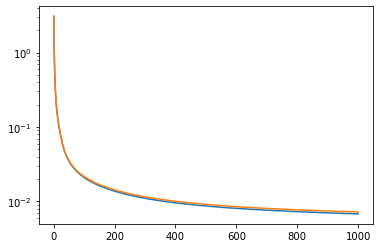

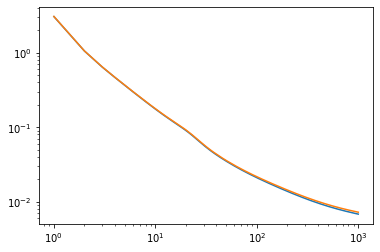

In [10]:

plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.yscale('log')

#plt.ylim(10**(-5),10**(1))
#plt.xlim(1,1000)

plt.show()


plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.xscale('log')
plt.yscale('log')

plt.show()



### Learning rate

In [11]:

lr = 0.01
nepochs_adam = 1000


### Reset

In [12]:

for inet in range(num_models):
    nets[inet].load_state_dict(nets0[inet].state_dict())
    

### Training, Adam

In [13]:

rec_time = 1
nitera = int(nepochs_adam/rec_time)

running_trainloss_adam = torch.zeros( (nitera,num_models) )
running_testloss_adam = torch.zeros( (nitera,num_models) )

#itera = 0    

optimizers = [torch.optim.Adam(nets[inet].parameters(), lr=lr) for inet in range(num_models)]

for epoch in range(nepochs_adam):  # loop over the dataset multiple times

    if epoch%(nepochs_adam/100) == 0:
        print(epoch)
    #itera += 1

    for inet in range(num_models):
        
        # print statistics
        #if epoch % rec_time == rec_time-1:    # print every 'rec_time' mini-batches

        with torch.no_grad():

            outputs_train = nets[inet](inputs_train)
            running_trainloss_adam[epoch,inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

            outputs_test = nets[inet](inputs_test)
            running_testloss_adam[epoch,inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

        # Compute the loss
        outputs_train = nets[inet](inputs_train)
        loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2
        
        optimizers[inet].zero_grad()  # Clear gradients for this model
        loss.backward()              # Compute gradients for this model
        optimizers[inet].step()      # Update parameters for this model

print('Finished Training')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Finished Training


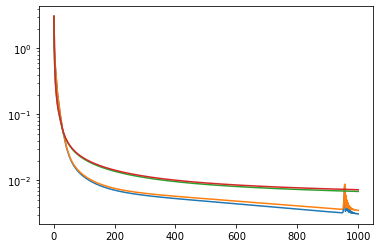

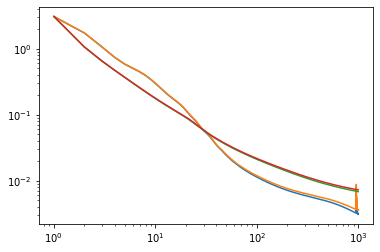

In [14]:

plt.plot(np.arange(1,nepochs_adam+1),running_trainloss_adam)
plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam)
plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.yscale('log')

#plt.ylim(10**(-5),10**(1))
#plt.xlim(1,1000)

plt.show()


plt.plot(np.arange(1,nepochs_adam+1),running_trainloss_adam)
plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam)
plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.xscale('log')
plt.yscale('log')

plt.show()


### Learning rate

In [52]:

alpha = 0.06
beta = 0.96

eps = 0.

betah = 0.95

nepochs_symo = 500




### Reset

In [84]:

for inet in range(num_models):
    nets[inet].load_state_dict(nets0[inet].state_dict())
    

### Training, ensemble cov

In [85]:

rec_time = 1
nitera = int(nepochs_symo/rec_time)

running_trainloss_symo = torch.zeros( (nitera,num_models) )
running_testloss_symo = torch.zeros( (nitera,num_models) )

#phi_rec = np.zeros((L-2,nepochs_symo,num_models+1))
#PHI1_rec = np.zeros((dim[0],dim[0],nepochs_symo,num_models+1))
#PSI1_rec = np.zeros((dim[0],dim[2],nepochs_symo,num_models+1))
#PHIL_rec = np.zeros((dim[L],dim[L],nepochs_symo,num_models+1))

phi_mom = np.zeros((L-2,num_models))
PHI1_mom = np.zeros((dim[0],dim[0],num_models))
PSI1_mom = np.zeros((dim[0],dim[2],num_models))
PHIL_mom = np.zeros((dim[L],dim[L],num_models))

#grad_rec = np.zeros((num_parameters,num_models))
update_rec = np.zeros((num_parameters,nepochs_symo,num_models))

#itera = 0    

for epoch in range(nepochs_symo):  # loop over the dataset multiple times

    lr = alpha * beta**epoch
    
    if epoch%(nepochs_symo/100) == 0:
        print(epoch)
            
    for inet in range(num_models):
        
        with torch.no_grad():

            outputs_train = nets[inet](inputs_train)
            running_trainloss_symo[epoch,inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

            outputs_test = nets[inet](inputs_test)
            running_testloss_symo[epoch,inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

        #if epoch%(nepochs_symo/100) == 0:
            #print(running_trainloss_symo[epoch,inet])
        #itera += 1

        # Compute the loss
        outputs_train = nets[inet](inputs_train)
        loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

        # Compute first-order gradients
        grads = torch.autograd.grad(loss, nets[inet].parameters(), create_graph=False)

        grad_vec_F = torch.cat([g.T.reshape(-1,1) for g in grads])
        grad_vec_C = torch.cat([g.view(-1) for g in grads])
        
        grad_np = grad_vec_F.numpy()
        #grad_rec[:,inet] = grad_np.reshape((num_parameters,))
        
        #phi_rec[:,epoch,inet],PHI1_rec[:,:,epoch,inet],PSI1_rec[:,:,epoch,inet],PHIL_rec[:,:,epoch,inet] = sm.grad2par(L,dim,grad_np)
        
        '''
            #phi_rec[:,epoch,num_models],PHI1_rec[:,:,epoch,num_models],PSI1_rec[:,:,epoch,num_models],PHIL_rec[:,:,epoch,num_models] = sm.grad2par(L,dim,grad_rec)
            #phi = np.squeeze(phi_rec[:,epoch,num_models])
            #PHI1 = np.squeeze(PHI1_rec[:,:,epoch,num_models])
            #PSI1 = np.squeeze(PSI1_rec[:,:,epoch,num_models])
            #PHIL = np.squeeze(PHIL_rec[:,:,epoch,num_models])

            phi,PHI1,PSI1,PHIL = sm.grad2par(L,dim,grad_rec)

            phi = phi + eps
            PHI1 = PHI1 + eps * np.eye(dim[0])
            PHIL = PHIL + eps * np.eye(dim[L])

            phi,PHI1,PSI1,PHIL = sm.squareroot(L,dim,phi,PHI1,PSI1,PHIL)
            phi,PHI1,PSI1,PHIL = sm.inverse(L,dim,phi,PHI1,PSI1,PHIL)

            for inet in range(num_models):

        '''

        # momentum
        
        phi,PHI1,PSI1,PHIL = sm.grad2par(L,dim,grad_np)
        
        phi_mom[:,inet] = betah * phi_mom[:,inet] + (1-betah) * phi
        PHI1_mom[:,:,inet] = betah * PHI1_mom[:,:,inet] + (1-betah) * PHI1
        PSI1_mom[:,:,inet] = betah * PSI1_mom[:,:,inet] + (1-betah) * PSI1
        PHIL_mom[:,:,inet] = betah * PHIL_mom[:,:,inet] + (1-betah) * PHIL
        
        phi = np.squeeze(phi_mom[:,inet]) / (1-betah**(epoch+1))
        PHI1 = np.squeeze(PHI1_mom[:,:,inet]) / (1-betah**(epoch+1))
        PSI1 = np.squeeze(PSI1_mom[:,:,inet]) / (1-betah**(epoch+1))
        PHIL = np.squeeze(PHIL_mom[:,:,inet]) / (1-betah**(epoch+1))

        phi = phi + eps
        PHI1 = PHI1 + eps * np.eye(dim[0])
        PHIL = PHIL + eps * np.eye(dim[L])

        phi,PHI1,PSI1,PHIL = sm.squareroot(L,dim,phi,PHI1,PSI1,PHIL)
        phi,PHI1,PSI1,PHIL = sm.inverse(L,dim,phi,PHI1,PSI1,PHIL)
       
        #update_F = sm.matvec(L,dim, phi , PHI1 , PSI1 , PHIL , grad_rec[:,inet])
        update_F = sm.matvec(L,dim, phi , PHI1 , PSI1 , PHIL , grad_np)
        update_C = np.copy(update_F)

        # normalize by layer
        #for iL in range(L):
        #    update_F[cpar[iL]:cpar[iL+1]] /= np.sqrt(np.var(update_F[cpar[iL]:cpar[iL+1]])) 
        
        update_rec[:,epoch,inet] = update_F
        
        for iL in range(L):
            upd = update_F[cpar[iL]:cpar[iL+1]].reshape((dim[iL+1],dim[iL]),order='F')
            update_C[cpar[iL]:cpar[iL+1]]=np.reshape(upd,(dim[iL+1]*dim[iL],),order='C')

        param_vec = torch.nn.utils.parameters_to_vector(nets[inet].parameters())
        torch.nn.utils.vector_to_parameters( param_vec - lr * torch.tensor(update_C).float() , nets[inet].parameters())    


print('Finished Training')


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
Finished Training


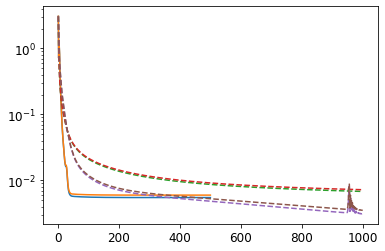

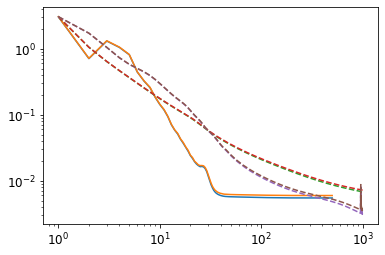

In [86]:

plt.plot(np.arange(1,nepochs_symo+1),running_trainloss_symo)
plt.plot(np.arange(1,nepochs_symo+1),running_testloss_symo)

plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')

plt.plot(np.arange(1,nepochs_adam+1),running_trainloss_adam,linestyle='dashed')
plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam,linestyle='dashed')

#plt.xscale('log')
plt.yscale('log')

#plt.ylim(10**(-5),10**(1))
#plt.xlim(0,200)

plt.show()



plt.plot(np.arange(1,nepochs_symo+1),running_trainloss_symo)
plt.plot(np.arange(1,nepochs_symo+1),running_testloss_symo)

#plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
#plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')
plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd[:,0],linestyle='dashed')
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd[:,0],linestyle='dashed')

#plt.plot(np.arange(1,nepochs_adam+1),running_trainloss_adam,linestyle='dashed')
#plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam,linestyle='dashed')
plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_adam[:,0],linestyle='dashed')
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_adam[:,0],linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

plt.show()

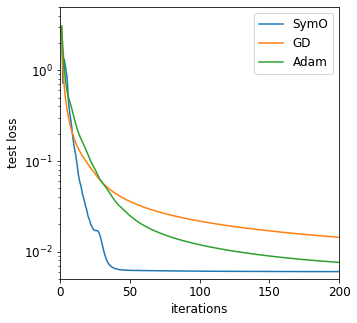

In [93]:

plt.rc('font', size = 12)

plt.plot(np.arange(1,nepochs_symo+1),running_testloss_symo[:,0], label='SymO')
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd[:,0], label='GD')
plt.plot(np.arange(1,nepochs_adam+1),running_testloss_adam[:,0], label='Adam')

#plt.xscale('log')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('test loss')

plt.ylim(0.005,5)
plt.xlim(0,200)

plt.legend()

fig = plt.gcf()
fig.set_size_inches(5, 5)

#plt.savefig('optimization_Tanh.pdf',bbox_inches="tight")

plt.show()




In [88]:


inet = 0

varupd = np.zeros((L,nepochs_symo))

for iL in range(L):
    for epoch in range(nepochs_symo):
        varupd[iL,epoch] = np.var(update_rec[cpar[iL]:cpar[iL+1],epoch,inet])


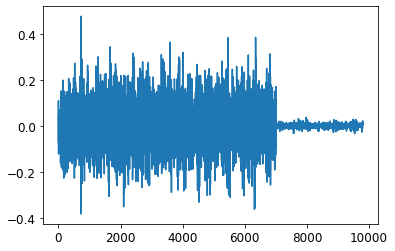

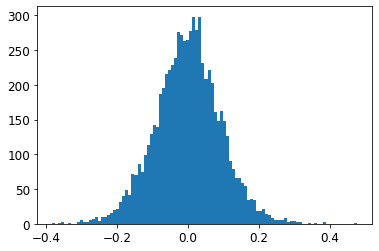

0.09215503027791254


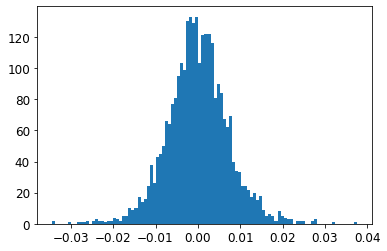

0.007317348997368931


In [89]:

epoch = 50
inet = 0

plt.plot(update_rec[:,epoch,inet])
plt.show()

for iL in range(L):
    plt.hist(update_rec[cpar[iL]:cpar[iL+1],epoch,inet],100)
    plt.show()
    
    print(np.sqrt(varupd[iL,epoch]))


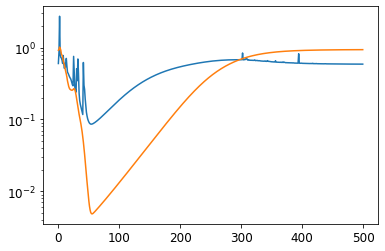

In [90]:

plt.plot(np.sqrt(varupd).T)
plt.yscale('log')
plt.show()


### Hyperparameter tuning, learning rate

In [98]:

nepochs_lr = 1000

nlr = 10

lrvec = np.logspace(-4,-1,nlr)

rec_time = 1
nitera = int(nepochs_lr/rec_time)

running_trainloss_lr = torch.zeros( (nlr,nitera,num_models) )
running_testloss_lr = torch.zeros( (nlr,nitera,num_models) )

for ilr, lr in enumerate(lrvec):

    print(lr)

    for inet in range(num_models):
        nets[inet].load_state_dict(nets0[inet].state_dict())
        
    phi_mom = np.zeros((L-2,num_models))
    PHI1_mom = np.zeros((dim[0],dim[0],num_models))
    PSI1_mom = np.zeros((dim[0],dim[2],num_models))
    PHIL_mom = np.zeros((dim[L],dim[L],num_models))

    #itera = 0    

    for epoch in range(nepochs_lr):  # loop over the dataset multiple times

        if epoch%(nepochs_lr/100) == 0:
            print(epoch)

        for inet in range(num_models):

            with torch.no_grad():

                outputs_train = nets[inet](inputs_train)
                running_trainloss_lr[ilr,epoch,inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

                outputs_test = nets[inet](inputs_test)
                running_testloss_lr[ilr,epoch,inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

            #itera += 1

            # Compute the loss
            outputs_train = nets[inet](inputs_train)
            loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

            # Compute first-order gradients
            grads = torch.autograd.grad(loss, nets[inet].parameters(), create_graph=False)

            grad_vec_F = torch.cat([g.T.reshape(-1,1) for g in grads])
            #grad_vec_C = torch.cat([g.view(-1) for g in grads])

            grad_np = grad_vec_F.numpy()

            phi,PHI1,PSI1,PHIL = sm.grad2par(L,dim,grad_np)

            phi_mom[:,inet] = betah * phi_mom[:,inet] + (1-betah) * phi
            PHI1_mom[:,:,inet] = betah * PHI1_mom[:,:,inet] + (1-betah) * PHI1
            PSI1_mom[:,:,inet] = betah * PSI1_mom[:,:,inet] + (1-betah) * PSI1
            PHIL_mom[:,:,inet] = betah * PHIL_mom[:,:,inet] + (1-betah) * PHIL

            phi = np.squeeze(phi_mom[:,inet]) / (1-betah**(epoch+1))
            PHI1 = np.squeeze(PHI1_mom[:,:,inet]) / (1-betah**(epoch+1))
            PSI1 = np.squeeze(PSI1_mom[:,:,inet]) / (1-betah**(epoch+1))
            PHIL = np.squeeze(PHIL_mom[:,:,inet]) / (1-betah**(epoch+1))

            phi = phi + eps
            PHI1 = PHI1 + eps * np.eye(dim[0])
            PHIL = PHIL + eps * np.eye(dim[L])

            phi,PHI1,PSI1,PHIL = sm.squareroot(L,dim,phi,PHI1,PSI1,PHIL)
            phi,PHI1,PSI1,PHIL = sm.inverse(L,dim,phi,PHI1,PSI1,PHIL)

            update_F = sm.matvec(L,dim,phi,PHI1,PSI1,PHIL,grad_np)
            update_C = np.copy(update_F)

            # normalize by layer
            #for iL in range(L):
            #    update_F[cpar[iL]:cpar[iL+1]] /= np.sqrt(np.var(update_F[cpar[iL]:cpar[iL+1]])) 
        
            for iL in range(L):
                upd = update_F[cpar[iL]:cpar[iL+1]].reshape((dim[iL+1],dim[iL]),order='F')
                update_C[cpar[iL]:cpar[iL+1]]=np.reshape(upd,(dim[iL+1]*dim[iL],),order='C')

            param_vec = torch.nn.utils.parameters_to_vector(nets[inet].parameters())
            torch.nn.utils.vector_to_parameters( param_vec - lr * torch.tensor(update_C).float() , nets[inet].parameters())    

    print('\n')




0.0001
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


0.00021544346900318845
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


0.00046415888336127773
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430


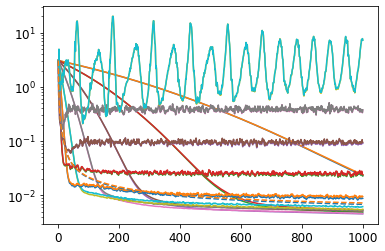

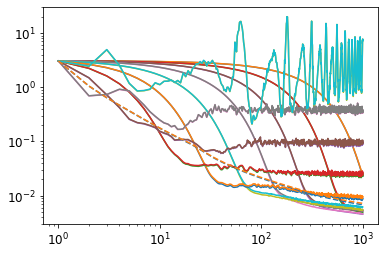

In [99]:



for ilr in range(nlr):
    for inet in range(num_models):
        plt.plot(np.arange(1,nepochs_lr+1),running_trainloss_lr[ilr,:,inet])
        plt.plot(np.arange(1,nepochs_lr+1),running_testloss_lr[ilr,:,inet])

plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')

#plt.xscale('log')
plt.yscale('log')

#plt.ylim(10**(-5),10**(1))
#plt.xlim(0,50)

plt.show()



for ilr in range(nlr):
    for inet in range(num_models):
        plt.plot(np.arange(1,nepochs_lr+1),running_trainloss_lr[ilr,:,inet])
        plt.plot(np.arange(1,nepochs_lr+1),running_testloss_lr[ilr,:,inet])

plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

plt.show()




In [ ]:

print(lrvec)
print('\n')
print(1/lrvec)


### Hyperparameter tuning, learning rate decay

In [26]:

nepochs_decay = 500

nalpha = 10
nbeta = 10

alphavec = np.logspace(-3,-1,nalpha)
betavec = 1 - np.logspace(-3,-1,nbeta)

rec_time = 1
nitera = int(nepochs_decay/rec_time)

running_trainloss_decay = torch.zeros( (nalpha,nbeta,nitera,num_models) )
running_testloss_decay = torch.zeros( (nalpha,nbeta,nitera,num_models) )

for ialpha, alpha in enumerate(alphavec):
    for ibeta, beta in enumerate(betavec):

        print(alpha)
        print(beta)

        for inet in range(num_models):
            nets[inet].load_state_dict(nets0[inet].state_dict())

        phi_mom = np.zeros((L-2,num_models))
        PHI1_mom = np.zeros((dim[0],dim[0],num_models))
        PSI1_mom = np.zeros((dim[0],dim[2],num_models))
        PHIL_mom = np.zeros((dim[L],dim[L],num_models))

        #itera = 0    

        for epoch in range(nepochs_decay):  # loop over the dataset multiple times

            lr = alpha * beta**epoch

            if epoch%(nepochs_decay/100) == 0:
                print(epoch)

            for inet in range(num_models):

                with torch.no_grad():

                    outputs_train = nets[inet](inputs_train)
                    running_trainloss_decay[ialpha,ibeta,epoch,inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

                    outputs_test = nets[inet](inputs_test)
                    running_testloss_decay[ialpha,ibeta,epoch,inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

                #itera += 1

                # Compute the loss
                outputs_train = nets[inet](inputs_train)
                loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

                # Compute first-order gradients
                grads = torch.autograd.grad(loss, nets[inet].parameters(), create_graph=False)

                grad_vec_F = torch.cat([g.T.reshape(-1,1) for g in grads])
                #grad_vec_C = torch.cat([g.view(-1) for g in grads])

                grad_np = grad_vec_F.numpy()

                phi,PHI1,PSI1,PHIL = sm.grad2par(L,dim,grad_np)

                phi_mom[:,inet] = betah * phi_mom[:,inet] + (1-betah) * phi
                PHI1_mom[:,:,inet] = betah * PHI1_mom[:,:,inet] + (1-betah) * PHI1
                PSI1_mom[:,:,inet] = betah * PSI1_mom[:,:,inet] + (1-betah) * PSI1
                PHIL_mom[:,:,inet] = betah * PHIL_mom[:,:,inet] + (1-betah) * PHIL

                phi = np.squeeze(phi_mom[:,inet]) / (1-betah**(epoch+1))
                PHI1 = np.squeeze(PHI1_mom[:,:,inet]) / (1-betah**(epoch+1))
                PSI1 = np.squeeze(PSI1_mom[:,:,inet]) / (1-betah**(epoch+1))
                PHIL = np.squeeze(PHIL_mom[:,:,inet]) / (1-betah**(epoch+1))

                phi = phi + eps
                PHI1 = PHI1 + eps * np.eye(dim[0])
                PHIL = PHIL + eps * np.eye(dim[L])

                phi,PHI1,PSI1,PHIL = sm.squareroot(L,dim,phi,PHI1,PSI1,PHIL)
                phi,PHI1,PSI1,PHIL = sm.inverse(L,dim,phi,PHI1,PSI1,PHIL)

                update_F = sm.matvec(L,dim,phi,PHI1,PSI1,PHIL,grad_np)
                update_C = np.copy(update_F)

                for iL in range(L):
                    upd = update_F[cpar[iL]:cpar[iL+1]].reshape((dim[iL+1],dim[iL]),order='F')
                    update_C[cpar[iL]:cpar[iL+1]]=np.reshape(upd,(dim[iL+1]*dim[iL],),order='C')

                param_vec = torch.nn.utils.parameters_to_vector(nets[inet].parameters())
                torch.nn.utils.vector_to_parameters( param_vec - lr * torch.tensor(update_C).float() , nets[inet].parameters())    

    print('\n')




0.001
0.999
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
0.001
0.9983318994628
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
0.001
0.9972174405977928
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255

20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
0.0027825594022071257
0.9983318994628
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
0.0027825594022071257
0.9972174405977928
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
2

410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495


0.007742636826811269
0.999
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
0.007742636826811269
0.9983318994628
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
0.007742636826811269
0.9972174405977928
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105


295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495


0.021544346900318832
0.999
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
0.021544346900318832
0.9983318994628
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
0.021544346900

180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495


0.05994842503189409
0.999
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
0.05994842503189409
0.9983318994628
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400


275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495




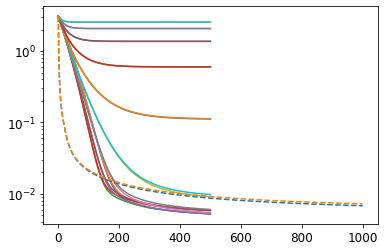

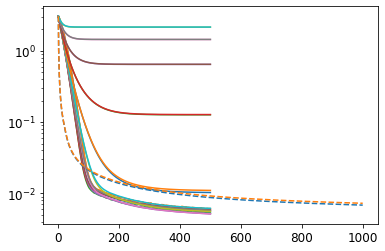

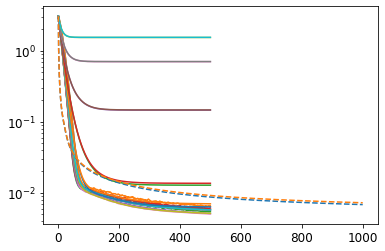

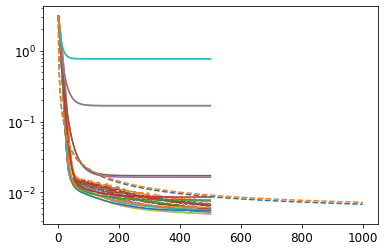

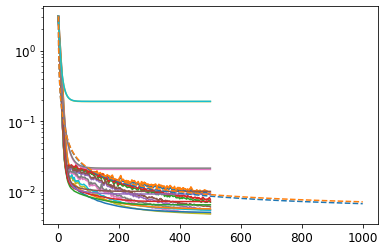

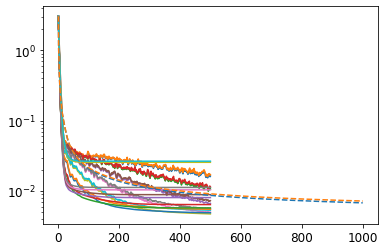

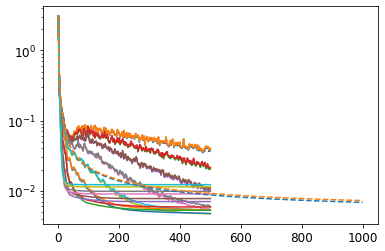

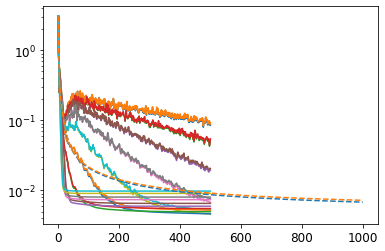

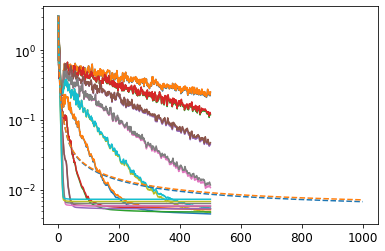

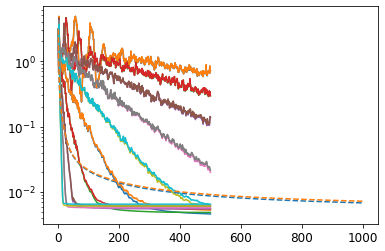

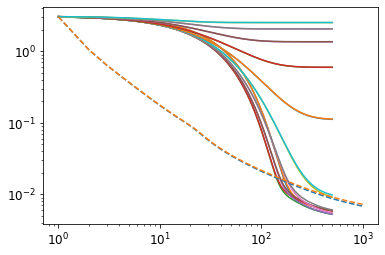

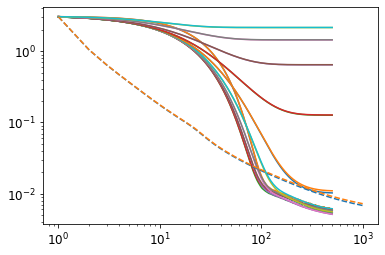

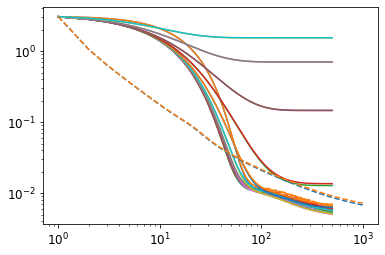

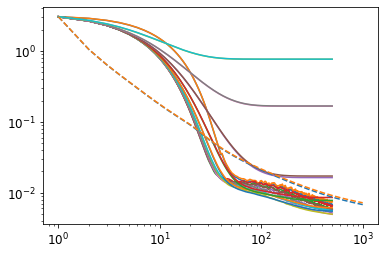

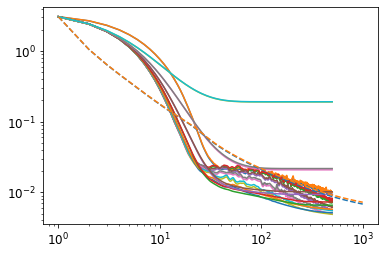

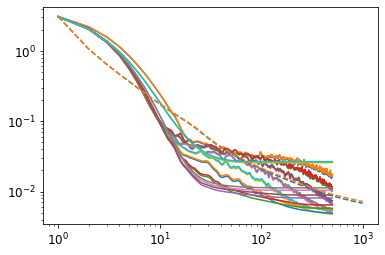

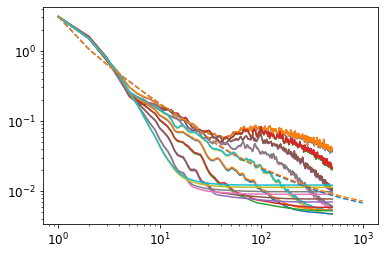

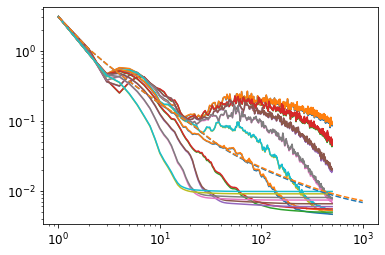

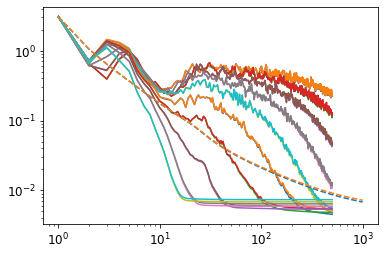

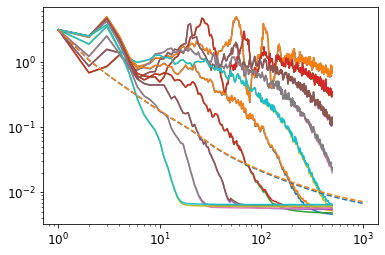

In [27]:

for ialpha in range(nalpha):
    for ibeta in range(nbeta):
        for inet in range(num_models):
            plt.plot(np.arange(1,nepochs_decay+1),running_trainloss_decay[ialpha,ibeta,:,inet])
            plt.plot(np.arange(1,nepochs_decay+1),running_testloss_decay[ialpha,ibeta,:,inet])

    plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
    plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')

    #plt.xscale('log')
    plt.yscale('log')

    plt.show()



for ialpha in range(nalpha):
    for ibeta in range(nbeta):
        for inet in range(num_models):
            plt.plot(np.arange(1,nepochs_decay+1),running_trainloss_decay[ialpha,ibeta,:,inet])
            plt.plot(np.arange(1,nepochs_decay+1),running_testloss_decay[ialpha,ibeta,:,inet])

    plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
    plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')

    plt.xscale('log')
    plt.yscale('log')

    plt.show()



In [ ]:

print(alphavec)
print('\n')
print(betavec)


In [28]:

print(np.nanmin(running_trainloss_decay))
print(np.nanmin(running_testloss_decay))


0.0045495788
0.0052155377


In [50]:

bestbeta = np.nanargmin(running_testloss_decay[:,:,99,0],axis=1)


In [51]:

print(bestbeta)
print('\n')

for ialpha in range(nalpha):

    print(running_testloss_decay[ialpha,bestbeta[ialpha],199,0])
    print(alphavec[ialpha])
    print(betavec[bestbeta[ialpha]])
    print('\n')



[1 1 3 5 5 6 6 6 7 8]


tensor(0.0093)
0.001
0.9983318994628


tensor(0.0083)
0.0016681005372000592
0.9983318994628


tensor(0.0078)
0.0027825594022071257
0.9953584111663872


tensor(0.0076)
0.004641588833612777
0.9870845033498512


tensor(0.0070)
0.007742636826811269
0.9870845033498512


tensor(0.0069)
0.01291549665014884
0.9784556530996812


tensor(0.0063)
0.021544346900318832
0.9784556530996812


tensor(0.0058)
0.03593813663804626
0.9784556530996812


tensor(0.0059)
0.05994842503189409
0.9640618633619538


tensor(0.0062)
0.1
0.9400515749681059




In [ ]:

for inet in range(num_models):
    plt.plot(np.arange(1,nepochs+1),running_trainloss_decay[6,6,:,inet])
    plt.plot(np.arange(1,nepochs+1),running_testloss_decay[6,6,:,inet])

plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')

#plt.xscale('log')
plt.yscale('log')

plt.show()


for inet in range(num_models):
    plt.plot(np.arange(1,nepochs+1),running_trainloss_decay[6,6,:,inet])
    plt.plot(np.arange(1,nepochs+1),running_testloss_decay[6,6,:,inet])

plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd,linestyle='dashed')
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd,linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

plt.show()


### Hyperparameter tuning, learning rate and damping

In [29]:

nepochs = 500
neps = 10
nlr = 10

lrvec = np.logspace(-4,-1,nlr)
epsvec = np.logspace(-9,0,neps)

rec_time = 1
nitera = int(nepochs/rec_time)

trainloss = np.zeros((nlr,neps))
testloss = np.zeros((nlr,neps))

for ilr, lr in enumerate(lrvec):
    for ieps, eps in enumerate(epsvec):

        for inet in range(num_models):
            nets[inet].load_state_dict(nets0[inet].state_dict())
            
        phi_mom = np.zeros((L-2,num_models))
        PHI1_mom = np.zeros((dim[0],dim[0],num_models))
        PSI1_mom = np.zeros((dim[0],dim[2],num_models))
        PHIL_mom = np.zeros((dim[L],dim[L],num_models))

        for epoch in range(nepochs):  # loop over the dataset multiple times

            for inet in range(num_models):

                with torch.no_grad():
                    outputs_train = nets[inet](inputs_train)
                    outputs_test = nets[inet](inputs_test)

                # Compute the loss
                outputs_train = nets[inet](inputs_train)
                loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

                # Compute first-order gradients
                grads = torch.autograd.grad(loss, nets[inet].parameters(), create_graph=False)

                grad_vec_F = torch.cat([g.T.reshape(-1,1) for g in grads])
                grad_vec_C = torch.cat([g.view(-1) for g in grads])

                grad_np = grad_vec_F.numpy()

                phi,PHI1,PSI1,PHIL = sm.grad2par(L,dim,grad_np)

                phi_mom[:,inet] = betah * phi_mom[:,inet] + (1-betah) * phi
                PHI1_mom[:,:,inet] = betah * PHI1_mom[:,:,inet] + (1-betah) * PHI1
                PSI1_mom[:,:,inet] = betah * PSI1_mom[:,:,inet] + (1-betah) * PSI1
                PHIL_mom[:,:,inet] = betah * PHIL_mom[:,:,inet] + (1-betah) * PHIL

                phi = np.squeeze(phi_mom[:,inet]) / (1-betah**(epoch+1))
                PHI1 = np.squeeze(PHI1_mom[:,:,inet]) / (1-betah**(epoch+1))
                PSI1 = np.squeeze(PSI1_mom[:,:,inet]) / (1-betah**(epoch+1))
                PHIL = np.squeeze(PHIL_mom[:,:,inet]) / (1-betah**(epoch+1))

                phi = phi + eps
                PHI1 = PHI1 + eps * np.eye(dim[0])
                PHIL = PHIL + eps * np.eye(dim[L])

                phi,PHI1,PSI1,PHIL = sm.squareroot(L,dim,phi,PHI1,PSI1,PHIL)
                phi,PHI1,PSI1,PHIL = sm.inverse(L,dim,phi,PHI1,PSI1,PHIL)

                update_F = sm.matvec(L,dim,phi,PHI1,PSI1,PHIL,grad_np)
                update_C = np.copy(update_F)

                for iL in range(L):
                    upd = update_F[cpar[iL]:cpar[iL+1]].reshape((dim[iL+1],dim[iL]),order='F')
                    update_C[cpar[iL]:cpar[iL+1]]=np.reshape(upd,(dim[iL+1]*dim[iL],),order='C')

                param_vec = torch.nn.utils.parameters_to_vector(nets[inet].parameters())
                torch.nn.utils.vector_to_parameters( param_vec - lr * torch.tensor(update_C).float() , nets[inet].parameters())    

        trainloss[ilr,ieps] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2
        testloss[ilr,ieps] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

        print(lr)
        print(eps)
        print(trainloss[ilr,ieps])
        print(testloss[ilr,ieps])
        print('\n')





0.0001
1e-09
0.4368094205856323
0.4382286071777344


0.0001
1e-08
0.44357559084892273
0.4450823664665222


0.0001
1e-07
0.45530620217323303
0.45684024691581726


0.0001
1e-06
0.4769829213619232
0.4784732460975647


0.0001
1e-05
0.5256991982460022
0.5271744728088379


0.0001
0.0001
0.6577550172805786
0.6594159007072449


0.0001
0.001
1.0080596208572388
1.0104129314422607


0.0001
0.01
1.677130103111267
1.6824431419372559


0.0001
0.1
2.387993574142456
2.3977701663970947


0.0001
1.0
2.8058114051818848
2.818186044692993


0.00021544346900318845
1e-09
0.020017845556139946
0.02076592855155468


0.00021544346900318845
1e-08
0.02361574023962021
0.0244370736181736


0.00021544346900318845
1e-07
0.03129275515675545
0.03223229944705963


0.00021544346900318845
1e-06
0.04710192605853081
0.048177286982536316


0.00021544346900318845
1e-05
0.0830409899353981
0.08426651358604431


0.00021544346900318845
0.0001
0.17743796110153198
0.17887699604034424


0.00021544346900318845
0.001
0.4258212745189667

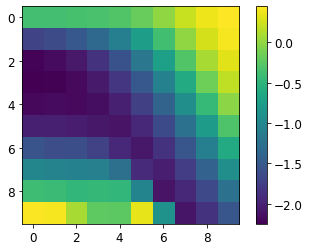

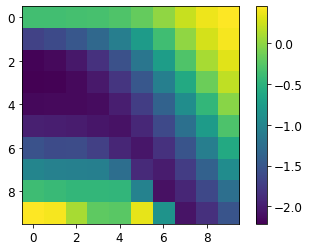

In [30]:

plt.imshow(np.log10(trainloss))
plt.colorbar()
plt.show()

plt.imshow(np.log10(testloss))
plt.colorbar()
plt.show()



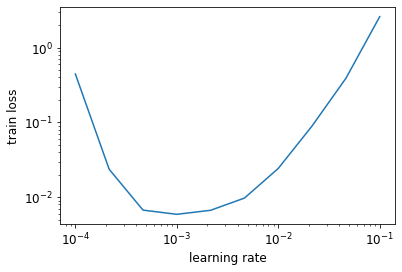

1e-08
0.001
0.005905603989958763




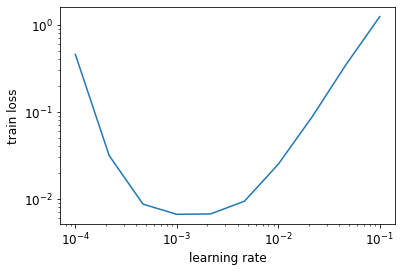

1e-07
0.001
0.006614565849304199




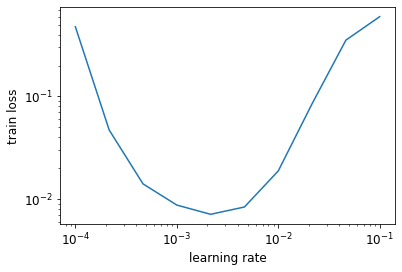

1e-06
0.002154434690031882
0.007112637162208557




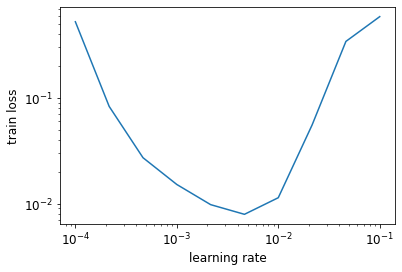

1e-05
0.004641588833612777
0.00791400857269764




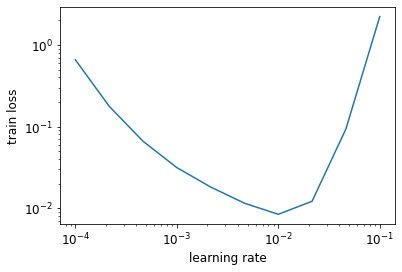

0.0001
0.01
0.00842747837305069




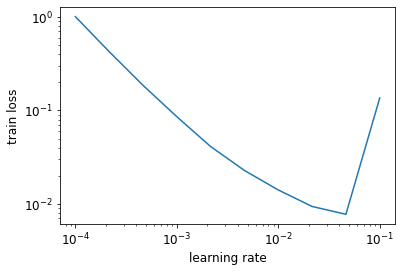

0.001
0.046415888336127774
0.007744127884507179




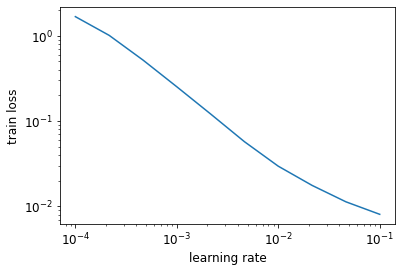

0.01
0.1
0.008060060441493988




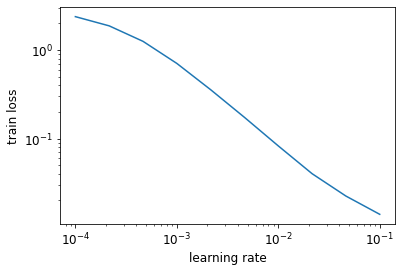

0.1
0.1
0.013948286883533001




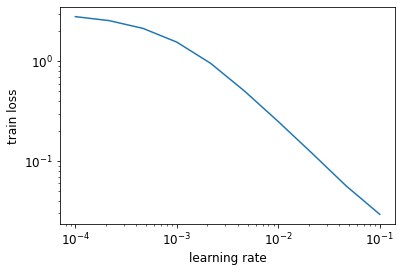

1.0
0.1
0.02942575328052044




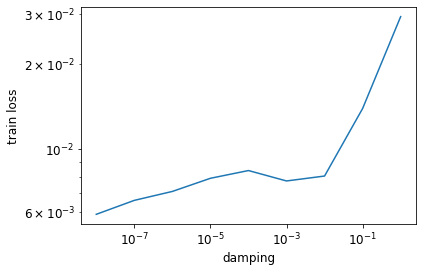

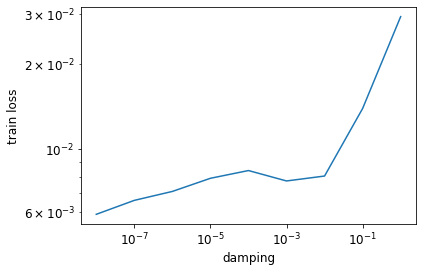

In [31]:

besttrainloss=np.zeros((neps,))
besttestloss=np.zeros((neps,))

for ieps, eps in enumerate(epsvec):
    if ieps>0:
        plt.plot(lrvec,trainloss[:,ieps])
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('learning rate')
        plt.ylabel('train loss')
        plt.show()
        print(eps)
        print(lrvec[np.nanargmin(trainloss[:,ieps])])
        print(np.nanmin(trainloss[:,ieps]))
        print('\n')
        besttrainloss[ieps]=np.nanmin(trainloss[:,ieps])
        besttestloss[ieps]=np.nanmin(testloss[:,ieps])


plt.plot(epsvec[1:10],besttrainloss[1:10])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('damping')
plt.ylabel('train loss')
plt.show()

plt.plot(epsvec[1:10],besttrainloss[1:10])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('damping')
plt.ylabel('train loss')
plt.show()



### Save experiment

In [ ]:

#PATH = './mlp_iGD.pt'
#torch.save({'do':d0, 'd1':d1, 'd':d, 'L':L, 'num_train_data':num_train_data, 'num_test_data':num_test_data, 'noise':noise, 'lr':lr, 'nepochs':nepochs, 'rec_time':rec_time, 'running_trainloss':running_trainloss, 'running_testloss':running_testloss, 'tol':tol}, PATH)

#PATH = './mlp_up_iGD.pt'
#torch.save({'do':d0, 'd1':d1, 'd':d, 'L':L, 'num_train_data':num_train_data, 'num_test_data':num_test_data, 'noise':noise, 'lr':lr, 'nepochs':nepochs, 'rec_time':rec_time, 'running_trainloss':running_trainloss, 'running_testloss':running_testloss, 'tol':tol}, PATH)

